Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Author: Lulof Pirée
March 2021

Copyright (C) 2020 Lulof Pirée, Teun Schilperoort

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Backprob experiment

This file provides a full run of backpropagating though an entire `NenwinModel`.

Author: Lulof Pirée

In [70]:
import torch
import torch.nn as nn
import torchviz

from nenwin.all_particles import Marble, Node, MarbleEaterNode, MarbleEmitterNode
from nenwin.model import NenwinModel
from nenwin.attraction_functions.attraction_functions import NewtonianGravity

## Approach

1. Decide how to capture output and network architecture.
1. Set up the model and the particles.
1. Add a loss function.
1. Visualize the model.
1. Run the model.
1. Backpropagate and update.
1. Compare differences in model.

### Design
Let's create a ring of Nodes, say 5 of them, and put one Marble in there. Not in the center, just somewhere within the circle of space (let's keep it 2D) enclosed by the ring of Nodes.
Now let the loss simply be the distance of the Marble to the center of the circle **after 5 seconds from the start**.

One likely result -- if everything works -- is that the Marble simply is placed stationary on this position. But that would already be some successfull optimization!

In [90]:
zero = torch.tensor([0, 0], dtype=torch.float)
mass = 10

center = torch.tensor([0, 0], dtype=torch.float, requires_grad=False)
node_positions = [torch.tensor(pos, dtype=torch.float) for pos in ((0, 10), (10, 0), (0, -10), (-10, 0))]
marble_pos = torch.tensor([2, 2], dtype=torch.float)

nodes = [Node(pos, zero, zero, mass, NewtonianGravity(), 1, 1, 1, 1) 
    for pos in node_positions]

marble = Marble(marble_pos, zero, zero, mass, NewtonianGravity(), None)

model = NenwinModel(nodes, (marble,))

optimizer = torch.optim.Adam(model.parameters())

torch.autograd.set_detect_anomaly(True)

step_size = 5

for epoch in range(25):
    optimizer.zero_grad(set_to_none=True)

    marble.zero_grad(set_to_none=True)
    print(f"Before reset epoch {epoch}")
    print(marble.init_pos._version)


    # model.reset()
    marble.zero_grad(set_to_none=True)
    marble.reset()
    
    for node in nodes:
        node.reset()
        node.zero_grad(set_to_none=True)
    
    print(f"being epoch {epoch}")
    print(marble.init_pos._version)
    
    t = 0
    while t <= 5:
        model.make_timestep(step_size)
        t += step_size

    # loss = torch.abs(marble.pos[0]) #+ torch.abs(marble.pos[1])
    # loss = torch.mean(torch.pow(marble.pos - torch.tensor([0, 0], dtype=torch.float), 2))
    # print(loss)

    print(f"end epoch {epoch}")
    print(marble.init_pos._version)
    marble.pos[0].backward()
    # loss.backward(retain_graph=True)
    optimizer.step()


Before reset epoch 0
0
being epoch 0
0
end epoch 0
0
Before reset epoch 1
1
being epoch 1
1
end epoch 1
1


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []] is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

## Try it with a single Marble -- do the same errors happen?

end epoch 0
0
0
0
end epoch 1
1
0
1
Error occured
prev_prev: 0
prev: 0
init: 1


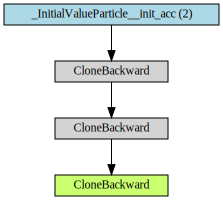

In [86]:
marble = Marble(marble_pos, zero, zero, mass, NewtonianGravity(), None)
optimizer = torch.optim.Adam(marble.parameters())
step_time=0.5


for epoch in range(25):
    optimizer.zero_grad(set_to_none=True)

    marble.zero_grad(set_to_none=True)
    marble.reset()
    # print(vars(marble))
    t = 0
    while t <= 5:
        marble.update_movement(time_passed=step_time)
        t += step_size

    loss = torch.mean(torch.pow(marble.pos - torch.tensor([0, 0], dtype=torch.float), 2))

    print(f"end epoch {epoch}")
    print(marble.init_pos._version)
    print(marble._PhysicalParticle__mass._version)
    print(marble._InitialValueParticle__init_pos._version)

    try:
        loss.backward()
        del loss
        optimizer.step()
    except:
        print("Error occured")
        break
print("prev_prev:", marble._prev_prev_acc._version)
print("prev:", marble._prev_acc._version)
print("init:", marble.init_acc._version)
torchviz.make_dot(marble._prev_acc, params=dict(marble.named_parameters()))


In [73]:
import torchvision

In [83]:
help(torchviz.make_dot)

Help on function make_dot in module torchviz.dot:

make_dot(var, params=None)
    Produces Graphviz representation of PyTorch autograd graph.
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)



In [87]:
a = torch.tensor([1.0], requires_grad = True)
a[0] += 1
a._version

2

In [88]:
b = a.clone()
b._version

0

In [91]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.my_param = nn.Parameter(torch.tensor([1.0], requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.my_param

In [96]:
mm = MyModule()
optim = torch.optim.Adam(mm.parameters())

for epoch in range(2):
    optim.zero_grad()
    loss = mm(torch.tensor([2.0]))
    loss.backward()
    optim.step()
print(mm.my_param._version)
print(mm(torch.tensor([2.0]))._version)
print(loss._version)

2
0
0
